<a href="https://colab.research.google.com/github/20211931/phishing-detection/blob/main/oss_project_machinelearning_%EC%88%98%EC%A0%95_%EC%82%AC%ED%95%AD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install beautifulsoup4 whois requests pandas scikit-learn matplotlib seaborn

URL데이터 파일 업로드

In [23]:
import pandas as pd

# CSV 파일 로드
file_path = '/valid_data.csv'
data = pd.read_csv(file_path)

# 데이터 확인
print(data.head())

                         url  IP_LIKE   AT  URL_Depth  Redirection  Is_Https  \
0   https://cazasolution.com      0.0  0.0        0.0         -1.0       1.0   
1   https://cedarandmoss.com      0.0  0.0        0.0         -1.0       1.0   
2     https://cfesuccess.com      0.0  0.0        0.0         -1.0       1.0   
3  https://cgitoronto.gov.in      0.0  0.0        0.0         -1.0       1.0   
4  https://chaletnicholas.ca      0.0  0.0        0.0         -1.0       1.0   

   TINY_URL  Check_Hyphen  Query  Domain_Age  Domain_end  Mouseover  \
0       0.0           0.0    0.0        -1.0        -1.0        0.0   
1       0.0           0.0    0.0        -1.0         0.0        0.0   
2       0.0           0.0    0.0        -1.0        -1.0        0.0   
3       0.0           0.0    0.0        -1.0         0.0        1.0   
4       0.0           0.0    0.0        -1.0        -1.0        0.0   

   Web_forwards  Hyperlinks  Domain_Cons      Tokenized_url  Label  
0           0.0        

피처 수집 함수 정의

In [24]:
import re
import urllib.parse
import whois
from datetime import datetime, timedelta

# 단축 URL 서비스 패턴 정의
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net|buff\.ly|rb\.gy|rebrand\.ly|short\.cm|clk\.im|cutt\.ly|t2m\.io|bl\.ink|" \
                      r"tiny\.cc"

def extract_features(url):
    """URL에서 피처를 추출하여 딕셔너리로 반환."""
    result = {}

    # 1. IP_LIKE: URL에 IP 주소가 포함되어 있는지 여부
    result['IP_LIKE'] = 1 if re.search(r"(?:\d{1,3}\.){3}\d{1,3}", url) else 0

    # 2. AT: URL에 '@' 포함 여부
    result['AT'] = 1 if "@" in url else 0

    # 3. URL_Depth: URL의 깊이
    path = urllib.parse.urlparse(url).path
    result['URL_Depth'] = len([segment for segment in path.split('/') if segment])

    # 4. Redirection: URL에 '//'가 두 번 이상 포함되어 있는지 여부
    result['Redirection'] = 1 if url.rfind('//') > 6 else 0

    # 5. Is_Https: HTTPS 사용 여부
    result['Is_Https'] = 1 if urllib.parse.urlsplit(url).scheme == 'https' else 0

    # 6. TINY_URL: 단축 URL 사용 여부
    result['TINY_URL'] = 1 if re.search(shortening_services, url) else 0

    # 7. Check_Hyphen: URL에 '-' 포함 여부
    result['Check_Hyphen'] = 1 if '-' in url else 0

    # 8. Query: URL의 쿼리 문자열 개수
    result['Query'] = len(url.split('?')[-1].split('&')) if '?' in url else 0

    # 9. Domain_Age: 도메인의 생성 기간
    try:
        domain_name = urllib.parse.urlsplit(url).netloc
        domain_info = whois.whois(domain_name)
        creation_date = domain_info.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        if isinstance(creation_date, datetime):
            result['Domain_Age'] = 0 if creation_date <= datetime.today() - timedelta(days=365) else 1
        else:
            result['Domain_Age'] = 1
    except:
        result['Domain_Age'] = 1

    # 10. Domain_end: 도메인의 만료 기간
    try:
        expiration_date = domain_info.expiration_date
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]
        if isinstance(expiration_date, datetime):
            result['Domain_end'] = 1 if (expiration_date - datetime.today()).days / 30 < 5 else 0
        else:
            result['Domain_end'] = 1
    except:
        result['Domain_end'] = 1

    return result


 피처 수집 실행 및 데이터프레임 생성

In [25]:
# 결측값 제거 및 문자열 변환
data = data[data['url'].notnull()]
data['url'] = data['url'].astype(str)

# 피처 생성
features = data['url'].apply(extract_features)

# 피처 데이터프레임 생성
features_df = pd.DataFrame(features.tolist())

# 기존 데이터프레임과 결합
data = pd.concat([data, features_df], axis=1)

# 데이터 확인
print(data.head())


<ipython-input-25-402d8d9196b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['url'] = data['url'].astype(str)


                         url  IP_LIKE   AT  URL_Depth  Redirection  Is_Https  \
0   https://cazasolution.com      0.0  0.0        0.0         -1.0       1.0   
1   https://cedarandmoss.com      0.0  0.0        0.0         -1.0       1.0   
2     https://cfesuccess.com      0.0  0.0        0.0         -1.0       1.0   
3  https://cgitoronto.gov.in      0.0  0.0        0.0         -1.0       1.0   
4  https://chaletnicholas.ca      0.0  0.0        0.0         -1.0       1.0   

  TINY_URL  Check_Hyphen  Query  Domain_Age  ...  IP_LIKE   AT  URL_Depth  \
0      0.0           0.0    0.0        -1.0  ...      0.0  0.0        0.0   
1      0.0           0.0    0.0        -1.0  ...      0.0  0.0        0.0   
2      0.0           0.0    0.0        -1.0  ...      0.0  0.0        0.0   
3      0.0           0.0    0.0        -1.0  ...      0.0  0.0        0.0   
4      0.0           0.0    0.0        -1.0  ...      0.0  0.0        0.0   

   Redirection  Is_Https TINY_URL  Check_Hyphen  Query  

데이터 전처리

In [26]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 전처리
data = data.fillna(0)
data = data.select_dtypes(exclude=['object'])

# MinMaxScaler 적용
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)


머신러닝 모델 학습

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 초기화 및 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

모델 성능 평가

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10038
         1.0       1.00      1.00      1.00      3962

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000

Accuracy: 1.0


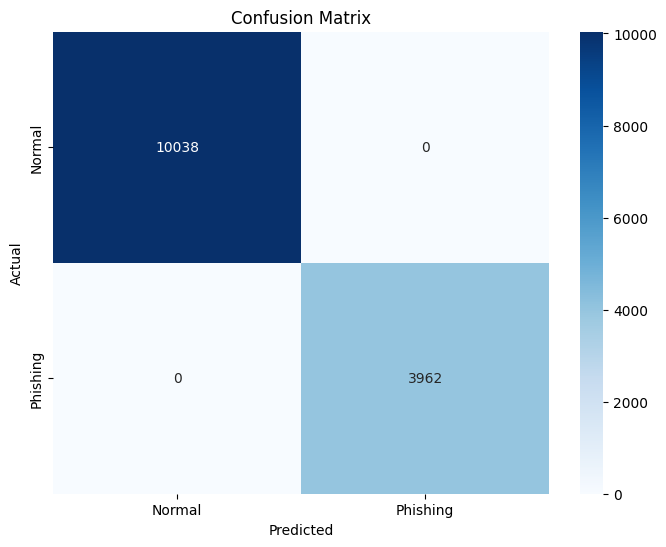

In [28]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측
y_pred = model.predict(X_test)

# 평가
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

하이퍼파라미터 튜닝

In [29]:
# 하이퍼파라미터 튜닝
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(100, 501),
    'max_depth': randint(5, 21),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': uniform(0.5, 0.5)
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_distributions,
    n_iter=50,
    cv=3,
    n_jobs=2,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# 튜닝된 모델 평가 및 저장
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))
print("Accuracy (Tuned Model):", accuracy_score(y_test, y_pred_best))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10038
         1.0       1.00      1.00      1.00      3962

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000

Accuracy (Tuned Model): 1.0


모델 저장

In [30]:
# 모델 저장
import os
import joblib


# 모델 저장 경로 설정
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'tuned_phishing_model.pkl')
joblib.dump(best_model, model_path)
print(f"Tuned phishing model saved to: {model_path}")

Tuned phishing model saved to: models/tuned_phishing_model.pkl
